This script reproduces the QC plots in Figure 2 of the manuscript M. D. Luecken and F. J. Theis, "Best practices in single-cell RNA-seq analysis".

In [1]:
import scanpy.api as sc
import numpy as np
import scipy as sp
from scipy.io import mmread
from scipy.sparse import csr_matrix
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
from maren_codes import combat as c
from gprofiler import gprofiler

import warnings
from rpy2.rinterface import RRuntimeWarning
from rpy2.robjects import pandas2ri


%load_ext rpy2.ipython

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures

# Load in the data

The data here was obtained from same publication as the case study (Haber et al., 2018; GSE92332). Please refer to the case study for more details on how to obtain the data.

In [3]:
# Set up data loading

#Data files
sample_strings = ['Duo_M1', 'Duo_M2', 'Jej_M1', 'Jej_M2', 'Il_M1', 'Il_M2']
sample_id_strings = ['3', '4', '5', '6', '7', '8']
file_base = '../data/Haber-et-al_mouse-intestinal-epithelium/GSE92332_RAW/GSM283657' 
exp_string = '_Regional_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'

In [4]:
# Loop to load rest of data sets
#Parse Filenames
sample = sample_strings.pop(0)
sample_id = sample_id_strings.pop(0)
data_file = file_base+sample_id+exp_string+sample+data_file_end
barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
gene_file = file_base+sample_id+exp_string+sample+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
adata.X = adata.X.toarray()

barcodes = pd.read_table(barcode_file, header=None)
genes = pd.read_table(gene_file, header=None)

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['region'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['donor'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:'id', 1:'gene_symbol'}, inplace=True)
genes.set_index('id', inplace=True)
adata.var = genes


In [5]:
# First data set load & annotation
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    sample_id = sample_id_strings[i]
    data_file = file_base+sample_id+exp_string+sample+data_file_end
    barcode_file = file_base+sample_id+exp_string+sample+barcode_file_end
    gene_file = file_base+sample_id+exp_string+sample+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    adata_tmp.X = adata_tmp.X.toarray()
    
    barcodes_tmp = pd.read_table(barcode_file, header=None)
    genes_tmp = pd.read_table(gene_file, header=None)
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['region'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['donor'] = [sample.split("_")[1]]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('id', inplace=True)
    adata_tmp.var = genes_tmp

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample_id')
    adata.var['gene_symbol'] = adata.var['gene_symbol-1']
    adata.var.drop(columns = ['gene_symbol-1', 'gene_symbol-0'], inplace=True)
    adata.obs.drop(columns=['sample_id'], inplace=True)

In [6]:
#Assign variable names and gene symbol columns
adata.var_names = [g.split("_")[1] for g in adata.var_names]
adata.var['gene_symbol'] = [g.split("_")[1] for g in adata.var['gene_symbol']]

Once the data is read in and annotated, we test whether we have the expected number of cells for each region, mouse (donor), and sample.

In [7]:
# Annotate the data sets
print(adata.obs['region'].value_counts())
print('')
print(adata.obs['donor'].value_counts())
print('')
print(adata.obs['sample'].value_counts())

Duo    4554
Jej    4496
Il     4303
Name: region, dtype: int64

M2    6711
M1    6642
Name: donor, dtype: int64

Jej_M2    2668
Il_M1     2466
Duo_M1    2348
Duo_M2    2206
Il_M2     1837
Jej_M1    1828
Name: sample, dtype: int64


We have 4554, 4496, and 4303 cells from the Duodenum, Jejunum, and Ileum respectively.

In [8]:
# Checking the total size of the data set
adata.shape

(13353, 27998)

We have 13,353 cells and 27,998 genes in the dataset.

# Quality control

In [9]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var['gene_symbol']]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

... storing 'sample' as categorical
... storing 'region' as categorical
... storing 'donor' as categorical
... storing 'gene_symbol' as categorical
/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)


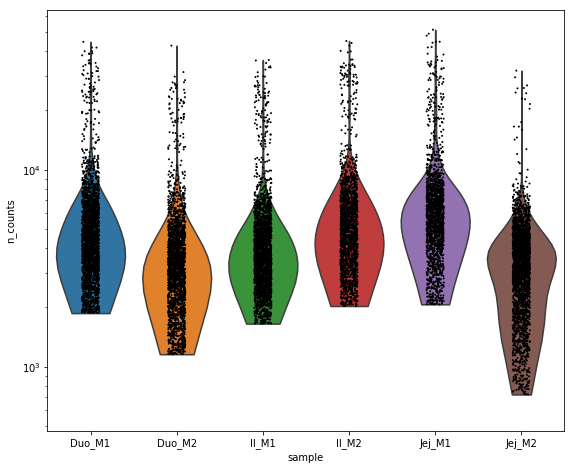

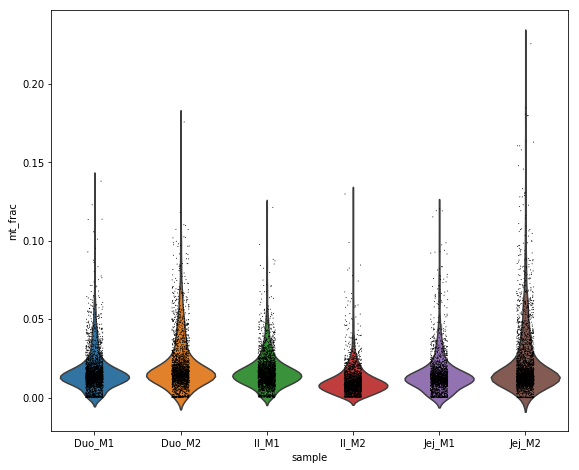

In [10]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='sample', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='sample')

## QC plots

In [11]:
lab_size = 25
tick_size = 15

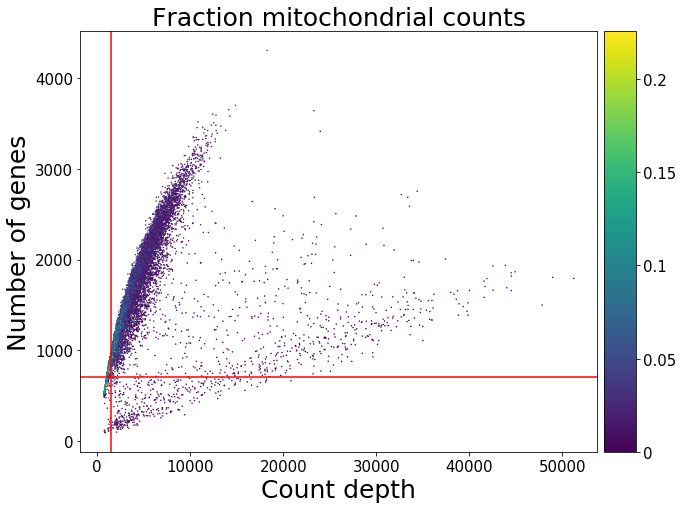

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


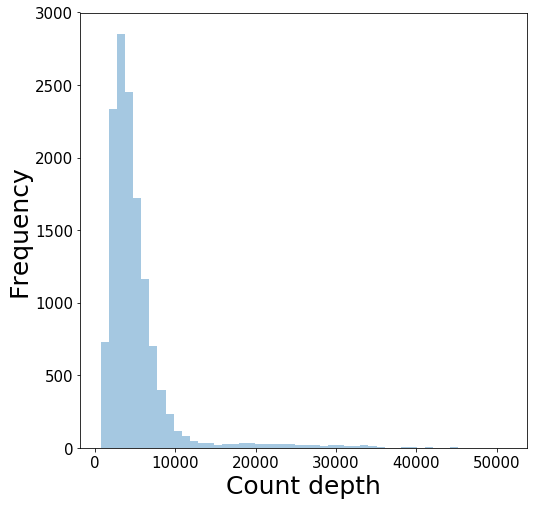

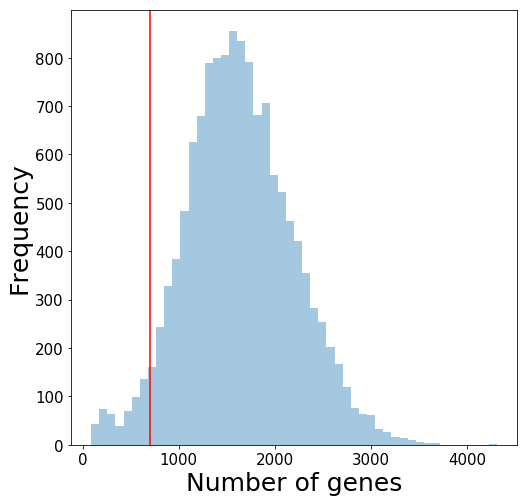

In [12]:
#p1, ax = plt.subplots()
ax = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', show=False, legend_fontweight=50)
ax.set_title('Fraction mitochondrial counts', fontsize=lab_size)
ax.set_xlabel("Count depth",fontsize=lab_size)
ax.set_ylabel("Number of genes",fontsize=lab_size)
ax.tick_params(labelsize=tick_size)
ax.axhline(700, 0,1, color='red')
ax.axvline(1500, 0,1, color='red')
fig = plt.gcf()
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=tick_size)
f1 = ax.get_figure()
f1.savefig('../figures/scatter_qc_gene_count_mtfrac.pdf')
plt.show()

p2 = sb.distplot(adata.obs['n_counts'], kde=False)
p2.set_xlabel("Count depth",fontsize=lab_size)
p2.set_ylabel("Frequency",fontsize=lab_size)
p2.tick_params(labelsize=tick_size)
f2 = p2.get_figure()
f2.savefig('../figures/hist_qc_count_depth.pdf')
plt.show()

p3 = sb.distplot(adata.obs['n_genes'], kde=False)
p3.set_xlabel("Number of genes",fontsize=lab_size)
p3.set_ylabel("Frequency",fontsize=lab_size)
p3.tick_params(labelsize=tick_size)
p3.axvline(700, 0,1, color='red')
f3 = p3.get_figure()
f3.savefig('../figures/hist_qc_num_genes.pdf')
plt.show()

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


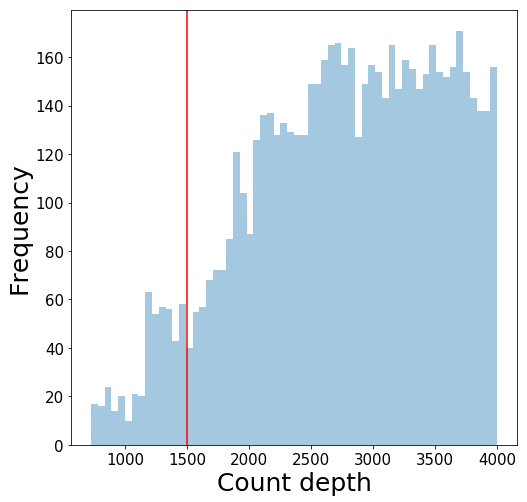

In [13]:
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
p4.set_xlabel("Count depth",fontsize=lab_size)
p4.set_ylabel("Frequency",fontsize=lab_size)
p4.tick_params(labelsize=tick_size)
p4.axvline(1500, 0,1, color='red')
f4 = p4.get_figure()
f4.savefig('../figures/hist_qc_count_depth_zoom.pdf')
plt.show()

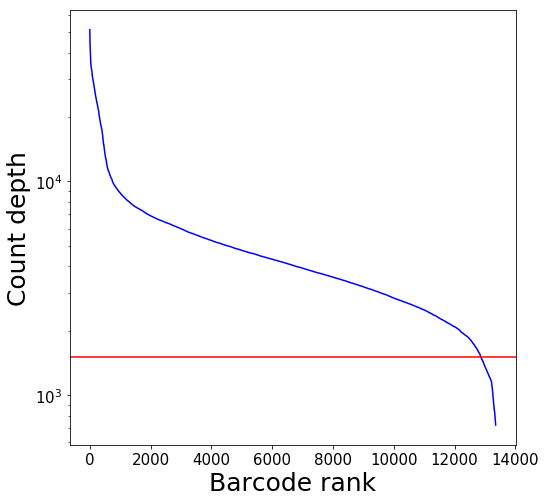

In [14]:
count_data = adata.obs['n_counts'].copy()
count_data.sort_values(inplace=True, ascending=False)
order =  range(1, len(count_data)+1)
p5 = plt.semilogy(order, count_data, 'b-')
plt.gca().axhline(1500, 0,1, color='red')
plt.xlabel("Barcode rank", fontsize=lab_size)
plt.ylabel("Count depth", fontsize=lab_size)
plt.tick_params(labelsize=tick_size)
plt.plot()
#f4 = p4.get_figure()
plt.savefig('../figures/line_qc_log_count_depth.pdf')
plt.show()

In [15]:
adata

AnnData object with n_obs × n_vars = 13353 × 27998 
    obs: 'sample', 'region', 'donor', 'n_counts', 'log_counts', 'n_genes', 'mt_frac'
    var: 'gene_symbol'

/Users/malte.luecken/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


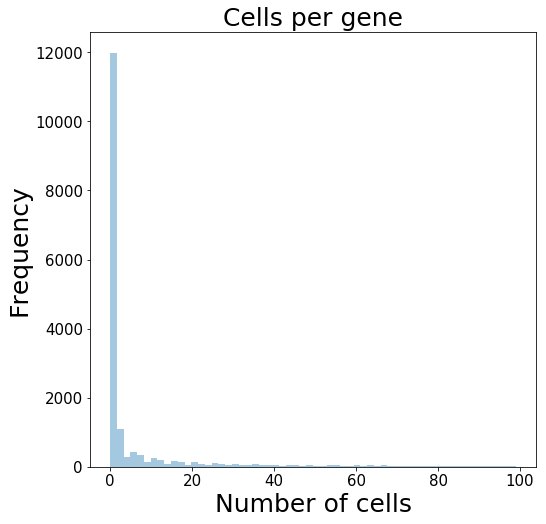

In [16]:
#Cells per gene
adata.var['cells_per_gene'] = np.sum(adata.X > 0, 0)

p6 = sb.distplot(adata.var['cells_per_gene'][adata.var['cells_per_gene'] < 100], kde=False, bins=60)
p6.set_xlabel("Number of cells",fontsize=lab_size)
p6.set_ylabel("Frequency",fontsize=lab_size)
p6.set_title('Cells per gene', fontsize=lab_size)
p6.tick_params(labelsize=tick_size)
plt.show()